In [1]:
import cv2
import sys
import os
import time
import dlib
import random
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt

from sklearn.model_selection  import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Convolution2D, MaxPooling2D,SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import SGD
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
from keras import layers
from keras.utils.data_utils import get_file
from keras.models import Model


Using TensorFlow backend.


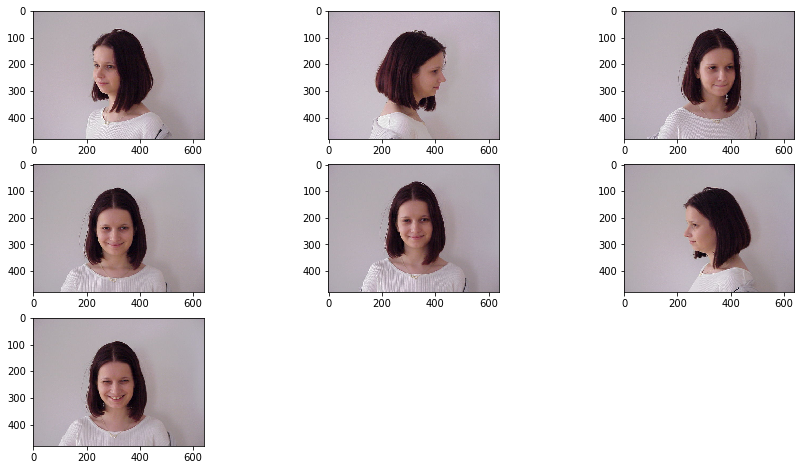

In [2]:
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0) # 显示大小
i=1
#展示数据集
patchPath='/home/ray/code/faceRecognition/FaceDB/database/'
for fileName in os.listdir(os.path.join(patchPath,'1')):
    if fileName.endswith('.HTM'):
        continue
    image=cv2.imread(patchPath+'1/'+fileName)
    img = image[...,::-1]
    axis=plt.subplot(3,len(os.listdir(os.path.join(patchPath,'1')))/3+1,i)
    plt.imshow(img)
    i+=1
plt.show()

In [3]:
#首先使用dlib库进行人脸检测
cascPath = "haarcascade_frontalface_default.xml"
dataPath='D:\\code\\pycode\\faceRecognition\\database\\'
patchPath='D:\\code\\pycode\\faceRecognition\\faceData\\'
dataPath='/home/ray/code/faceRecognition/FaceDB/database/'
patchPath='/home/ray/code/faceRecognition/FaceDB/faceData/'
faceCascade = cv2.CascadeClassifier(cascPath)
for personFolder in os.listdir(dataPath):
    personPath=os.path.join(dataPath,personFolder)
    for fileName in os.listdir(personPath):
        #遍历文件夹下所有图片
        if fileName.endswith('.HTM'):
            continue
        image = cv2.imread(os.path.join(personPath,fileName))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #将图片转为灰度模式
        faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(30, 30))
        if(len(faces)==1):
            x,y,w,h=list(faces[0])
            facePatch=image[y:y+h,x:x+w]
            if(not os.path.exists(os.path.join(patchPath,personFolder))):
                os.mkdir(os.path.join(patchPath,personFolder)) 
            #保存所有检测到的人脸
            cv2.imwrite(os.path.join(patchPath+personFolder,fileName),facePatch)

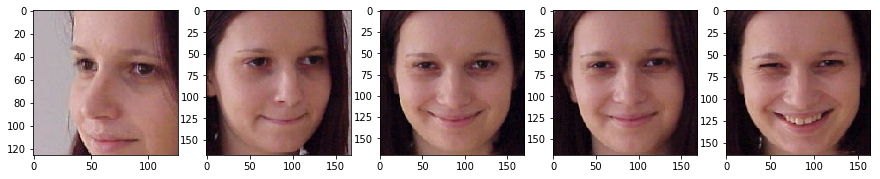

In [4]:
i=1
#对监测到的的人脸进行可视化
patchPath='/home/ray/code/faceRecognition/FaceDB/faceData/'
for fileName in os.listdir(os.path.join(patchPath,'1')):
    image=cv2.imread(patchPath+'1/'+fileName)
    img = image[...,::-1]
    axis=plt.subplot(1,len(os.listdir(os.path.join(patchPath,'1'))),i)
    plt.imshow(img)
    i+=1
plt.show()

In [5]:
#使用ImageDataGenerator进行数据增强
detector = dlib.get_frontal_face_detector()
dataPath='/home/ray/code/faceRecognition/FaceDB/database/'
patchPath='/home/ray/code/faceRecognition/FaceDB/faceData/'
detector = dlib.get_frontal_face_detector()
datagen = ImageDataGenerator(
        rotation_range=20,
#        width_shift_range=0.2,
#        height_shift_range=0.2,
        rescale=None,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        data_format='channels_last',
        cval=0,
        #channel_shift_range=0,
        vertical_flip=False)
for personFolder in os.listdir(dataPath):
    personPath=os.path.join(dataPath,personFolder)
    for fileName in os.listdir(personPath):
        if fileName.endswith('.HTM'):
            continue
        image = cv2.imread(os.path.join(personPath,fileName))
        dets = detector(image, 1)
        for i, d in enumerate(dets):
            print("person{} face{} Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(personFolder,fileName,i, d.left(), d.top(), d.right(), d.bottom()))
            facePatch=image[d.top():d.bottom(),d.left():d.right()]
            cv2.imwrite(os.path.join(patchPath+personFolder,fileName),facePatch)
            
            facePatch=img_to_array(facePatch)
            facePatch = facePatch.reshape((1,) + facePatch.shape)
            if(not os.path.exists(os.path.join(patchPath,personFolder))):
                os.mkdir(os.path.join(patchPath,personFolder)) 
                
            i = 0
            for batch in datagen.flow(facePatch, batch_size=1,
                                      save_to_dir=None#os.path.join(patchPath,personFolder), 
                                      #save_prefix=personFolder, 
                                      #save_format='jpeg'
                                      ):
                cv2.imwrite(os.path.join(patchPath+personFolder,fileName[:-4]+str(i)+'.JPG'),batch[0].astype(int))
                i += 1
                if i > 10:
                    break  # 否则生成器会退出循环
            


person11 faceMVC-004F.JPG Detection 0: Left: 159 Top: 180 Right: 345 Bottom: 366
person11 faceMVC-002F.JPG Detection 0: Left: 262 Top: 180 Right: 448 Bottom: 366
person11 faceMVC-006F.JPG Detection 0: Left: 201 Top: 180 Right: 386 Bottom: 366
person11 faceMVC-003F.JPG Detection 0: Left: 201 Top: 201 Right: 386 Bottom: 387
person11 faceMVC-007F.JPG Detection 0: Left: 221 Top: 180 Right: 407 Bottom: 366
person24 faceMVC-002F.JPG Detection 0: Left: 266 Top: 118 Right: 489 Bottom: 341
person24 faceMVC-006F.JPG Detection 0: Left: 221 Top: 118 Right: 407 Bottom: 304
person24 faceMVC-003F.JPG Detection 0: Left: 216 Top: 118 Right: 439 Bottom: 341
person24 faceMVC-007F.JPG Detection 0: Left: 142 Top: 142 Right: 365 Bottom: 365
person46 faceMVC-004F.JPG Detection 0: Left: 139 Top: 160 Right: 324 Bottom: 345
person46 faceMVC-002F.JPG Detection 0: Left: 266 Top: 142 Right: 489 Bottom: 365
person46 faceMVC-006F.JPG Detection 0: Left: 242 Top: 180 Right: 428 Bottom: 366
person46 faceMVC-003F.JPG De

person21 faceMVC-002F.JPG Detection 0: Left: 304 Top: 180 Right: 489 Bottom: 366
person21 faceMVC-006F.JPG Detection 0: Left: 221 Top: 201 Right: 407 Bottom: 387
person21 faceMVC-003F.JPG Detection 0: Left: 216 Top: 167 Right: 439 Bottom: 390
person21 faceMVC-007F.JPG Detection 0: Left: 201 Top: 201 Right: 386 Bottom: 387
person4 faceMVC-004F.JPG Detection 0: Left: 117 Top: 118 Right: 340 Bottom: 341
person4 faceMVC-006F.JPG Detection 0: Left: 180 Top: 180 Right: 366 Bottom: 366
person4 faceMVC-003F.JPG Detection 0: Left: 221 Top: 139 Right: 407 Bottom: 325
person4 faceMVC-007F.JPG Detection 0: Left: 201 Top: 139 Right: 386 Bottom: 325
person6 faceMVC-004F.JPG Detection 0: Left: 180 Top: 160 Right: 366 Bottom: 345
person6 faceMVC-002F.JPG Detection 0: Left: 266 Top: 167 Right: 489 Bottom: 390
person6 faceMVC-006F.JPG Detection 0: Left: 216 Top: 167 Right: 439 Bottom: 390
person6 faceMVC-003F.JPG Detection 0: Left: 221 Top: 180 Right: 407 Bottom: 366
person6 faceMVC-007F.JPG Detection 0

person41 faceMVC-003F.JPG Detection 0: Left: 191 Top: 167 Right: 414 Bottom: 390
person41 faceMVC-007F.JPG Detection 0: Left: 167 Top: 192 Right: 390 Bottom: 415
person67 faceMVC-002F.JPG Detection 0: Left: 304 Top: 167 Right: 459 Bottom: 322
person67 faceMVC-006F.JPG Detection 0: Left: 221 Top: 139 Right: 407 Bottom: 325
person67 faceMVC-003F.JPG Detection 0: Left: 218 Top: 150 Right: 373 Bottom: 305
person67 faceMVC-007F.JPG Detection 0: Left: 221 Top: 118 Right: 407 Bottom: 304
person72 faceMVC-006F.JPG Detection 0: Left: 221 Top: 160 Right: 407 Bottom: 345
person72 faceMVC-003F.JPG Detection 0: Left: 221 Top: 139 Right: 407 Bottom: 325
person72 faceMVC-007F.JPG Detection 0: Left: 191 Top: 142 Right: 414 Bottom: 365
person75 faceMVC-004F.JPG Detection 0: Left: 117 Top: 167 Right: 340 Bottom: 390
person75 faceMVC-006F.JPG Detection 0: Left: 201 Top: 180 Right: 386 Bottom: 366
person75 faceMVC-003F.JPG Detection 0: Left: 242 Top: 160 Right: 428 Bottom: 345
person75 faceMVC-007F.JPG De

person7 faceMVC-002F.JPG Detection 0: Left: 241 Top: 167 Right: 464 Bottom: 390
person7 faceMVC-006F.JPG Detection 0: Left: 221 Top: 201 Right: 407 Bottom: 387
person7 faceMVC-003F.JPG Detection 0: Left: 201 Top: 201 Right: 386 Bottom: 387
person7 faceMVC-007F.JPG Detection 0: Left: 242 Top: 180 Right: 428 Bottom: 366
person22 faceMVC-004F.JPG Detection 0: Left: 92 Top: 142 Right: 315 Bottom: 365
person22 faceMVC-002F.JPG Detection 0: Left: 291 Top: 167 Right: 513 Bottom: 390
person22 faceMVC-006F.JPG Detection 0: Left: 191 Top: 167 Right: 414 Bottom: 390
person22 faceMVC-003F.JPG Detection 0: Left: 216 Top: 167 Right: 439 Bottom: 390
person22 faceMVC-007F.JPG Detection 0: Left: 216 Top: 167 Right: 439 Bottom: 390
person98 faceMVC-002F.JPG Detection 0: Left: 242 Top: 160 Right: 428 Bottom: 345
person98 faceMVC-006F.JPG Detection 0: Left: 201 Top: 184 Right: 356 Bottom: 339
person98 faceMVC-003F.JPG Detection 0: Left: 236 Top: 202 Right: 390 Bottom: 356
person98 faceMVC-007F.JPG Detecti

person5 faceMVC-007F.JPG Detection 0: Left: 191 Top: 142 Right: 414 Bottom: 365
person68 faceMVC-004F.JPG Detection 0: Left: 180 Top: 139 Right: 366 Bottom: 325
person68 faceMVC-002F.JPG Detection 0: Left: 270 Top: 133 Right: 425 Bottom: 288
person68 faceMVC-006F.JPG Detection 0: Left: 236 Top: 150 Right: 390 Bottom: 305
person68 faceMVC-003F.JPG Detection 0: Left: 218 Top: 150 Right: 373 Bottom: 305
person68 faceMVC-007F.JPG Detection 0: Left: 184 Top: 150 Right: 339 Bottom: 305
person43 faceMVC-002F.JPG Detection 0: Left: 266 Top: 142 Right: 489 Bottom: 365
person43 faceMVC-006F.JPG Detection 0: Left: 221 Top: 160 Right: 407 Bottom: 345
person43 faceMVC-003F.JPG Detection 0: Left: 191 Top: 167 Right: 414 Bottom: 390
person43 faceMVC-007F.JPG Detection 0: Left: 221 Top: 180 Right: 407 Bottom: 366
person45 faceMVC-004F.JPG Detection 0: Left: 142 Top: 142 Right: 365 Bottom: 365
person45 faceMVC-002F.JPG Detection 0: Left: 291 Top: 142 Right: 513 Bottom: 365
person45 faceMVC-006F.JPG Det

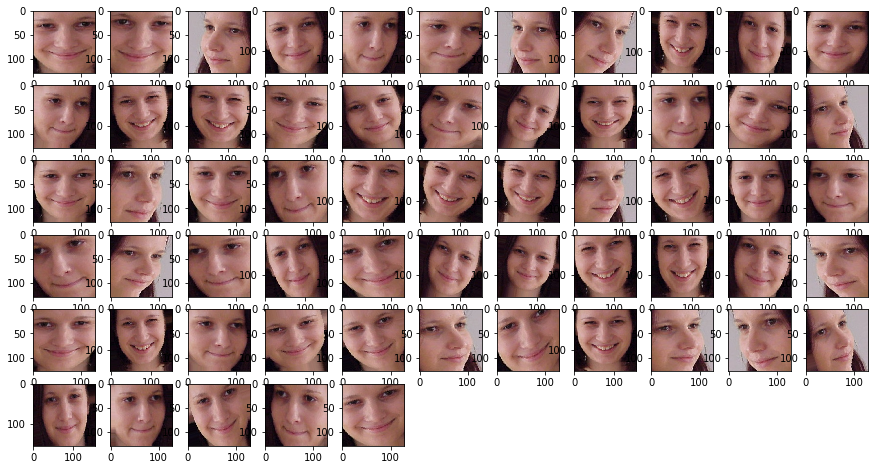

In [6]:
i=1
#展示数据增强的结果
patchPath='/home/ray/code/faceRecognition/FaceDB/faceData/'
for fileName in os.listdir(os.path.join(patchPath,'1')):
    image=cv2.imread(patchPath+'1/'+fileName)
    img = image[...,::-1]
    axis=plt.subplot(6,len(os.listdir(os.path.join(patchPath,'1')))/6+1,i)
    plt.imshow(img)
    i+=1
plt.show()

In [7]:
#读取所有人脸数据，并使用PCA进行降维
faceData=[[]]
label=[]
dataPath='/home/ray/code/faceRecognition/FaceDB/faceData/'

for dataLabel in os.listdir(dataPath):
    folderPath=os.path.join(dataPath,dataLabel)
    for fileName in os.listdir(folderPath):
        image=cv2.imread(os.path.join(folderPath,fileName))
        gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        imageArray=np.array(cv2.resize(gray_image,(101,101))).reshape([101*101])/255
        label.append(int(dataLabel))
        if(faceData==[[]]):
            faceData = [imageArray]
            continue
        faceData = np.concatenate((faceData, [imageArray]),axis=0)
pca = PCA(n_components=0.95)
pca.fit(faceData)
#print ("explained_variance_ratio_",pca.explained_variance_ratio_)
#print ("explained_variance_",pca.explained_variance_)
print ("pca.n_components_",pca.n_components_)
label=np.array(label)
faceData=pca.transform(faceData)
train_images, test_images, train_labels, test_labels = train_test_split(faceData, label, test_size = 0.1, random_state = random.randint(0, 100)) 

/home/ray/.conda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  del sys.path[0]


pca.n_components_ 228


In [8]:
#使用SVM进行分类
svc = SVC(gamma='auto')
svc.fit(train_images,train_labels)   #训练模型

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [9]:
test_pred=svc.predict(test_images)   #用测试数据来做预测
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         7
           2       0.50      0.17      0.25         6
           3       0.50      0.60      0.55         5
           4       0.50      0.33      0.40         3
           5       1.00      0.67      0.80         3
           6       1.00      0.33      0.50         6
           7       0.50      0.67      0.57         6
           8       0.17      1.00      0.29         1
           9       0.86      1.00      0.92         6
          10       0.50      0.67      0.57         6
          11       0.27      0.75      0.40         4
          12       0.80      0.57      0.67         7
          13       0.86      0.86      0.86         7
          14       0.12      0.33      0.18         3
          15       0.50      0.25      0.33         4
          16       0.71      0.83      0.77         6
          17       1.00      0.90      0.95        10
          18       0.67    

/home/ray/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
clf = RandomForestClassifier(n_jobs=114)
clf.fit(train_images,train_labels) 

/home/ray/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=114,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
test_pred=clf.predict(test_images)  #用测试数据来做预测
print(classification_report(test_labels,test_pred))

              precision    recall  f1-score   support

           1       0.22      0.71      0.33         7
           2       0.09      0.50      0.16         6
           3       0.04      0.20      0.06         5
           4       0.07      0.33      0.12         3
           5       0.11      0.67      0.18         3
           6       0.27      0.50      0.35         6
           7       0.14      0.50      0.22         6
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         6
          10       0.38      0.50      0.43         6
          11       0.08      0.25      0.12         4
          12       0.00      0.00      0.00         7
          13       0.10      0.14      0.12         7
          14       0.12      0.67      0.20         3
          15       0.08      0.25      0.12         4
          16       0.22      0.33      0.27         6
          17       0.11      0.10      0.11        10
          18       0.17    

/home/ray/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
IMAGE_SIZE = 101
images = []
labels = []
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels.h5'

In [19]:
MODEL_PATH='D:\\code\\pycode\\faceRecognition\\models.h5'
MODEL_PATH='/home/ray/code/faceRecognition/models.h5'
def read_path(path_name):    
    for dir in os.listdir(path_name):
        picFolderPath=os.path.join(path_name,dir)
        #print(dir+' '+str(len(os.listdir(picFolderPath))))
        for picname in os.listdir(picFolderPath):
            if(picname.endswith('JPG')):
                labels.append(int(dir))
                image = cv2.imread(os.path.join(picFolderPath,picname))
                image=cv2.resize(image,(101, 101), interpolation=cv2.INTER_CUBIC)
                images.append(image)
    return images,labels


In [20]:
#从指定路径读取训练数据
def load_dataset(path_name):
    images,labels = read_path(path_name)    
    
    #将输入的所有图片转成四维数组，尺寸为(图片数量*IMAGE_SIZE*IMAGE_SIZE*3)
    images = np.array(images)
    print(images.shape)    
    return images, labels

In [21]:
class Dataset:
    def __init__(self, path_name):
        #训练集
        self.train_images = None
        self.train_labels = None
        
        #验证集
        self.valid_images = None
        self.valid_labels = None
        
        #测试集
        self.test_images  = None            
        self.test_labels  = None
        
        #数据集加载路径
        self.path_name    = path_name
        
        #当前库采用的维度顺序
        self.input_shape = None
        
    #加载数据集并按照交叉验证的原则划分数据集并进行相关预处理工作
    def load(self, img_rows = 101, img_cols = 101, 
             img_channels = 3, nb_classes = 114):
        #加载数据集到内存
        images, labels = load_dataset(self.path_name)  
        train_images, test_valid_images, train_labels, test_valid_labels = train_test_split(images, labels, test_size = 0.2, random_state = random.randint(0, 100)) 
        valid_images, test_images, valid_labels, test_labels = train_test_split(test_valid_images, test_valid_labels, test_size = 0.5, random_state = random.randint(0, 100)) 
        
        #train_images, valid_images, train_labels, valid_labels = train_test_split(images, labels, test_size = 0.3, random_state = random.randint(0, 100))        
        #_, test_images, _, test_labels = train_test_split(images, labels, test_size = 0.5, random_state = random.randint(0, 100))                
        
        #当前的维度顺序如果为'th'，则输入图片数据时的顺序为：channels,rows,cols，否则:rows,cols,channels
        #这部分代码就是根据keras库要求的维度顺序重组训练数据集
        if K.image_dim_ordering() == 'th':
            train_images = train_images.reshape(train_images.shape[0], img_channels, img_rows, img_cols)
            valid_images = valid_images.reshape(valid_images.shape[0], img_channels, img_rows, img_cols)
            test_images = test_images.reshape(test_images.shape[0], img_channels, img_rows, img_cols)
            self.input_shape = (img_channels, img_rows, img_cols)            
        else:
            train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, img_channels)
            valid_images = valid_images.reshape(valid_images.shape[0], img_rows, img_cols, img_channels)
            test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, img_channels)
            self.input_shape = (img_rows, img_cols, img_channels)            
            
        #输出训练集、验证集、测试集的数量
        print(train_images.shape[0], 'train samples')
        print(valid_images.shape[0], 'valid samples')
        print(test_images.shape[0], 'test samples')
    
        #我们的模型使用categorical_crossentropy作为损失函数，因此需要根据类别数量nb_classes将
        #类别标签进行one-hot编码使其向量化，在这里我们的类别只有两种，经过转化后标签数据变为二维
#            train_labels = np_utils.to_categorical(train_labels, nb_classes)                        
#            valid_labels = np_utils.to_categorical(valid_labels, nb_classes)            
#            test_labels = np_utils.to_categorical(test_labels, nb_classes)                        
    
        #像素数据浮点化以便归一化
        train_images = train_images.astype('float32')            
        valid_images = valid_images.astype('float32')
        test_images = test_images.astype('float32')
        
        #将其归一化,图像的各像素值归一化到0~1区间
        train_images /= 255
        valid_images /= 255
        test_images /= 255            
        lb=LabelBinarizer().fit(np.array(range(0,nb_classes)))
        
        self.train_images = train_images
        self.valid_images = valid_images
        self.test_images  = test_images
        self.train_labels = lb.transform(train_labels)
        self.valid_labels = lb.transform(valid_labels)
        self.test_labels  = lb.transform(test_labels)

In [33]:
class myModel:
    def __init__(self):
        self.model = None 
        self.num_classes = 114
        self.weight_decay = 0.0005
        self.x_shape = [101,101,3]
        
    def buildXceptionModel(self,dataset,nb_classes=114):
        
        img_input = Input(shape=self.x_shape)

        # Block 1
        x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(64, (3, 3), use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
        residual = BatchNormalization()(residual)

        # Block 2
        x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        # Block 2 Pool
        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
        x = layers.add([x, residual])

        residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
        residual = BatchNormalization()(residual)

        # Block 3
        x = Activation('relu')(x)
        x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        # Block 3 Pool
        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
        x = layers.add([x, residual])

        residual = Conv2D(728, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
        residual = BatchNormalization()(residual)

        # Block 4
        x = Activation('relu')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
        x = layers.add([x, residual])

        # Block 5 - 12
        for i in range(8):
            residual = x
            x = Activation('relu')(x)
            x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
            x = BatchNormalization()(x)

            x = layers.add([x, residual])

        residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
        residual = BatchNormalization()(residual)

        # Block 13
        x = Activation('relu')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        # Block 13 Pool
        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
        x = layers.add([x, residual])

        # Block 14
        x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # Block 14 part 2
        x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # Fully Connected Layer
        x = GlobalAveragePooling2D()(x)
        x = Dense(nb_classes, activation='softmax')(x)

        inputs = img_input

        # Create model
        self.model = Model(inputs, x)

        # Download and cache the Xception weights file
        #weights_path = get_file('xception_weights.h5', WEIGHTS_PATH, cache_subdir='models')

        # load weights
       # self.model.load_weights(weights_path)
        self.model.summary()
    #建立模型
    def buildVGGModel(self, dataset, nb_classes = 114):
        #构建一个空的网络模型，它是一个线性堆叠模型，各神经网络层会被顺序添加，专业名称为序贯模型或线性堆叠模型
        self.model = Sequential() 
        weight_decay=self.weight_decay
        #以下代码将顺序添加CNN网络需要的各层，一个add就是一个网络层
        self.model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=self.x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.3))

        self.model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.4))

        self.model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.4))

        self.model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.4))

        self.model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        self.model.add(MaxPooling2D(pool_size=(2, 2)))


        self.model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.4))

        self.model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.4))

        self.model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        self.model.add(MaxPooling2D(pool_size=(2, 2)))


        self.model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.4))

        self.model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.4))

        self.model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.5))

        self.model.add(Flatten())
        self.model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        self.model.add(Activation('relu'))
        self.model.add(BatchNormalization())

        self.model.add(Dropout(0.5))
        self.model.add(Dense(nb_classes))
        self.model.add(Activation('softmax'))

        #输出模型概况
        self.model.summary()
        #训练模型
    def train(self, dataset, batch_size = 64, nb_epoch = 300, data_augmentation = False):        
        sgd = SGD(lr = 0.01, decay = 1e-6, 
                  momentum = 0.9, nesterov = True) #采用SGD+momentum的优化器进行训练，首先生成一个优化器对象  
        self.model.compile(loss='categorical_crossentropy',
                           optimizer=sgd,
                           metrics=['accuracy'])   #完成实际的模型配置工作
        
        #不使用数据提升，所谓的提升就是从我们提供的训练数据中利用旋转、翻转、加噪声等方法创造新的
        #训练数据，有意识的提升训练数据规模，增加模型训练量+          
        if not data_augmentation:            
            self.model.fit(dataset.train_images,
                           dataset.train_labels,
                           batch_size = batch_size,
                           nb_epoch = nb_epoch,
                           validation_data = (dataset.valid_images, dataset.valid_labels))
        #使用实时数据提升
        else:            
            #定义数据生成器用于数据提升，其返回一个生成器对象datagen，datagen每被调用一
            #次其生成一组数据（顺序生成），节省内存，其实就是python的数据生成器
            datagen = ImageDataGenerator(
                featurewise_center = False,             #是否使输入数据去中心化（均值为0），
                samplewise_center  = False,             #是否使输入数据的每个样本均值为0
                featurewise_std_normalization = False,  #是否数据标准化（输入数据除以数据集的标准差）
                samplewise_std_normalization  = False,  #是否将每个样本数据除以自身的标准差
                zca_whitening = False,                  #是否对输入数据施以ZCA白化
                rotation_range = 20,                    #数据提升时图片随机转动的角度(范围为0～180)
                width_shift_range  = 0.2,               #数据提升时图片水平偏移的幅度（单位为图片宽度的占比，0~1之间的浮点数）
                height_shift_range = 0.2,               #同上，只不过这里是垂直
                horizontal_flip = True,                 #是否进行随机水平翻转
                vertical_flip = False)                  #是否进行随机垂直翻转

            #计算整个训练样本集的数量以用于特征值归一化、ZCA白化等处理
            datagen.fit(dataset.train_images)                        

            #利用生成器开始训练模型
            self.model.fit_generator(datagen.flow(dataset.train_images, dataset.train_labels,
                                                   batch_size = batch_size),
                                     samples_per_epoch = dataset.train_images.shape[0],
                                     nb_epoch = nb_epoch,
                                     validation_data = (dataset.valid_images, dataset.valid_labels))
 
    def evaluate(self, dataset):
        score = self.model.evaluate(dataset.test_images, dataset.test_labels, verbose = 1)
        print("%s: %.2f%%" % (self.model.metrics_names[1], score[1] * 100))
    def save_model(self, file_path = MODEL_PATH):
        self.model.save(file_path)
    def load_model(self, file_path = MODEL_PATH):
        self.model = load_model(file_path)

In [23]:
dataset = Dataset('/home/ray/code/faceRecognition/FaceDB/faceData/')    #
dataset.load()

(5865, 101, 101, 3)
4692 train samples
586 valid samples
587 test samples


In [24]:
len(set(labels))

114

In [34]:
vggModel = myModel()

In [35]:
vggModel.buildVGGModel(dataset)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 101, 101, 64)      1792      
_________________________________________________________________
activation_51 (Activation)   (None, 101, 101, 64)      0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 101, 101, 64)      256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 101, 101, 64)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 101, 101, 64)      36928     
_________________________________________________________________
activation_52 (Activation)   (None, 101, 101, 64)      0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 101, 101, 64)      256       
__________

In [36]:
vggModel.train(dataset)

/home/ray/.conda/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 4692 samples, validate on 586 samples
Epoch 1/300
4692/4692 [==============================] - 48s 10ms/step - loss: 8.1742 - acc: 0.0337 - val_loss: 19.2957 - val_acc: 0.0085
Epoch 2/300
4692/4692 [==============================] - 46s 10ms/step - loss: 7.3364 - acc: 0.0923 - val_loss: 16.7139 - val_acc: 0.0017
Epoch 3/300
4692/4692 [==============================] - 47s 10ms/step - loss: 6.7512 - acc: 0.1569 - val_loss: 10.2620 - val_acc: 0.0119
Epoch 4/300
4692/4692 [==============================] - 47s 10ms/step - loss: 6.2982 - acc: 0.2159 - val_loss: 9.7916 - val_acc: 0.0307
Epoch 5/300
4692/4692 [==============================] - 47s 10ms/step - loss: 5.7473 - acc: 0.3043 - val_loss: 9.3032 - val_acc: 0.0375
Epoch 6/300
4692/4692 [==============================] - 47s 10ms/step - loss: 5.2837 - acc: 0.4020 - val_loss: 11.1744 - val_acc: 0.0546
Epoch 7/300
4692/4692 [==============================] - 47s 10ms/step - loss: 4.8643 - acc: 0.4925 - val_loss: 10.5574 - val_a

4692/4692 [==============================] - 47s 10ms/step - loss: 1.7069 - acc: 0.9648 - val_loss: 3.9809 - val_acc: 0.4898
Epoch 61/300
4692/4692 [==============================] - 47s 10ms/step - loss: 1.6762 - acc: 0.9725 - val_loss: 4.1181 - val_acc: 0.4863
Epoch 62/300
4692/4692 [==============================] - 47s 10ms/step - loss: 1.6551 - acc: 0.9685 - val_loss: 5.6101 - val_acc: 0.2935
Epoch 63/300
4692/4692 [==============================] - 47s 10ms/step - loss: 1.6183 - acc: 0.9751 - val_loss: 3.3771 - val_acc: 0.5887
Epoch 64/300
4692/4692 [==============================] - 47s 10ms/step - loss: 1.6037 - acc: 0.9744 - val_loss: 5.5746 - val_acc: 0.3106
Epoch 65/300
4692/4692 [==============================] - 47s 10ms/step - loss: 1.6087 - acc: 0.9631 - val_loss: 5.6920 - val_acc: 0.2952
Epoch 66/300
4692/4692 [==============================] - 47s 10ms/step - loss: 1.5714 - acc: 0.9736 - val_loss: 4.1194 - val_acc: 0.4727
Epoch 67/300
4692/4692 [=======================

4692/4692 [==============================] - 47s 10ms/step - loss: 0.8341 - acc: 0.9787 - val_loss: 2.5626 - val_acc: 0.6058
Epoch 120/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.8199 - acc: 0.9819 - val_loss: 1.9665 - val_acc: 0.7184
Epoch 121/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.8175 - acc: 0.9793 - val_loss: 3.0517 - val_acc: 0.5648
Epoch 122/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.8141 - acc: 0.9740 - val_loss: 10.8260 - val_acc: 0.0529
Epoch 123/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.8016 - acc: 0.9763 - val_loss: 1.5162 - val_acc: 0.7884
Epoch 124/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.7958 - acc: 0.9776 - val_loss: 2.5680 - val_acc: 0.6143
Epoch 125/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.7955 - acc: 0.9744 - val_loss: 2.2145 - val_acc: 0.6587
Epoch 126/300
4692/4692 [===============

4692/4692 [==============================] - 47s 10ms/step - loss: 0.4962 - acc: 0.9791 - val_loss: 1.0330 - val_acc: 0.8259
Epoch 179/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.5002 - acc: 0.9755 - val_loss: 11.0378 - val_acc: 0.1126
Epoch 180/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.4993 - acc: 0.9770 - val_loss: 2.1923 - val_acc: 0.6280
Epoch 181/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.5009 - acc: 0.9740 - val_loss: 3.3652 - val_acc: 0.5068
Epoch 182/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.5008 - acc: 0.9753 - val_loss: 1.1275 - val_acc: 0.8055
Epoch 183/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.4999 - acc: 0.9727 - val_loss: 0.7917 - val_acc: 0.8823
Epoch 184/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.5082 - acc: 0.9717 - val_loss: 8.6722 - val_acc: 0.1399
Epoch 185/300
4692/4692 [===============

4692/4692 [==============================] - 47s 10ms/step - loss: 0.3572 - acc: 0.9793 - val_loss: 0.9846 - val_acc: 0.8464
Epoch 238/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.3504 - acc: 0.9800 - val_loss: 2.1431 - val_acc: 0.6143
Epoch 239/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.3431 - acc: 0.9815 - val_loss: 0.9601 - val_acc: 0.8294
Epoch 240/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.3642 - acc: 0.9757 - val_loss: 1.9546 - val_acc: 0.6177
Epoch 241/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.3741 - acc: 0.9731 - val_loss: 1.4496 - val_acc: 0.7270
Epoch 242/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.3574 - acc: 0.9780 - val_loss: 3.6916 - val_acc: 0.4539
Epoch 243/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.3685 - acc: 0.9731 - val_loss: 0.4913 - val_acc: 0.9539
Epoch 244/300
4692/4692 [================

4692/4692 [==============================] - 47s 10ms/step - loss: 0.3482 - acc: 0.9714 - val_loss: 2.1922 - val_acc: 0.6092
Epoch 297/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.3639 - acc: 0.9672 - val_loss: 6.3003 - val_acc: 0.2918
Epoch 298/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.3290 - acc: 0.9793 - val_loss: 2.6303 - val_acc: 0.5666
Epoch 299/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.3171 - acc: 0.9827 - val_loss: 0.6389 - val_acc: 0.8908
Epoch 300/300
4692/4692 [==============================] - 47s 10ms/step - loss: 0.3348 - acc: 0.9757 - val_loss: 5.6294 - val_acc: 0.2645


In [37]:
vggModel.save_model('/home/ray/code/faceRecognition/VGGModel.h5')
vggModel.evaluate(dataset)

587/587 [==============================] - 2s 4ms/step
acc: 32.20%


In [28]:
XceptionModel= myModel()
XceptionModel.buildXceptionModel(dataset)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 3)  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 50, 50, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 50, 50, 32)   128         conv2d_14[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 50, 50, 32)   0           batch_normalization_15[0][0]     
__________________________________________________________________________________________________
conv2d_15 

In [30]:
XceptionModel.train(dataset)  

/home/ray/.conda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:249: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4692 samples, validate on 586 samples
Epoch 1/50
4692/4692 [==============================] - 28s 6ms/step - loss: 3.5765 - acc: 0.1475 - val_loss: 4.7183 - val_acc: 0.0137
Epoch 2/50
4692/4692 [==============================] - 26s 6ms/step - loss: 1.2226 - acc: 0.6451 - val_loss: 4.7371 - val_acc: 0.0119
Epoch 3/50
4692/4692 [==============================] - 26s 6ms/step - loss: 0.3835 - acc: 0.8885 - val_loss: 4.8291 - val_acc: 0.0102
Epoch 4/50
4692/4692 [==============================] - 26s 6ms/step - loss: 0.1475 - acc: 0.9569 - val_loss: 5.0600 - val_acc: 0.0102
Epoch 5/50
4692/4692 [==============================] - 27s 6ms/step - loss: 0.0961 - acc: 0.9665 - val_loss: 5.5799 - val_acc: 0.0119
Epoch 6/50
4692/4692 [==============================] - 27s 6ms/step - loss: 0.0518 - acc: 0.9774 - val_loss: 6.3961 - val_acc: 0.0154
Epoch 7/50
4692/4692 [==============================] - 26s 6ms/step - loss: 0.0246 - acc: 0.9838 - val_loss: 7.2953 - val_acc: 0.0171
Epoch 8/

In [32]:
XceptionModel.save_model('/home/ray/code/faceRecognition/XceptionModels.h5')#保存模型
XceptionModel.evaluate(dataset)#评估结果

587/587 [==============================] - 1s 2ms/step
acc: 97.10%
